In [1]:
!pip install tensorflow-recommenders
!pip install scann

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 1.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 12.6 MB/s 
     |████████████████████████████████| 511.7 MB 5.3 kB/s 
     |████████████████████████████████| 438 kB 65.8 MB/s 
     |████████████████████████████████| 5.8 MB 57.0 MB/s 
     |████████████████████████████████| 1.6 MB 53.1 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0

In [1]:
import os
import pprint
import tempfile

from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_recommenders as tfrs
import tensorflow_datasets as tfds
import pandas as pd
from IPython.display import Markdown, display, HTML
from copy import deepcopy
tf.compat.v1.enable_eager_execution()

In [26]:
data_path = os.path.join("drive","MyDrive","Colab Notebooks","data", "hotel_data")

interactions_df = pd.read_csv(os.path.join(data_path, "hotel_data_interactions_df.csv"), index_col=0)

base_item_features = ['term', 'length_of_stay_bucket', 'rate_plan', 'room_segment', 'n_people_bucket', 'weekend_stay']

column_values_dict = {
    'term': ['WinterVacation', 'Easter', 'OffSeason', 'HighSeason', 'LowSeason', 'MayLongWeekend', 'NewYear', 'Christmas'],
    'length_of_stay_bucket': ['[0-1]', '[2-3]', '[4-7]', '[8-inf]'],
    'rate_plan': ['Standard', 'Nonref'],
    'room_segment': ['[0-160]', '[160-260]', '[260-360]', '[360-500]', '[500-900]'],
    'n_people_bucket': ['[1-1]', '[2-2]', '[3-4]', '[5-inf]'],
    'weekend_stay': ['True', 'False']
}

interactions_df.loc[:, 'term'] = pd.Categorical(
    interactions_df['term'], categories=column_values_dict['term'])
interactions_df.loc[:, 'length_of_stay_bucket'] = pd.Categorical(
    interactions_df['length_of_stay_bucket'], categories=column_values_dict['length_of_stay_bucket'])
interactions_df.loc[:, 'rate_plan'] = pd.Categorical(
    interactions_df['rate_plan'], categories=column_values_dict['rate_plan'])
interactions_df.loc[:, 'room_segment'] = pd.Categorical(
    interactions_df['room_segment'], categories=column_values_dict['room_segment'])
interactions_df.loc[:, 'n_people_bucket'] = pd.Categorical(
    interactions_df['n_people_bucket'], categories=column_values_dict['n_people_bucket'])
interactions_df.loc[:, 'weekend_stay'] = interactions_df['weekend_stay'].astype('str')
interactions_df.loc[:, 'weekend_stay'] = pd.Categorical(
    interactions_df['weekend_stay'], categories=column_values_dict['weekend_stay'])

display(HTML(interactions_df.head(25).to_html()))

,user_id,item_id,term,length_of_stay_bucket,rate_plan,room_segment,n_people_bucket,weekend_stay
0,1,0,WinterVacation,[2-3],Standard,[260-360],[5-inf],True
1,2,1,WinterVacation,[2-3],Standard,[160-260],[3-4],True
2,3,2,WinterVacation,[2-3],Standard,[160-260],[2-2],False
3,4,3,WinterVacation,[4-7],Standard,[160-260],[3-4],True
4,5,4,WinterVacation,[4-7],Standard,[0-160],[2-2],True
5,6,5,Easter,[4-7],Standard,[260-360],[5-inf],True
6,7,6,OffSeason,[2-3],Standard,[260-360],[5-inf],True
7,8,7,HighSeason,[2-3],Standard,[160-260],[1-1],True
8,9,8,HighSeason,[2-3],Standard,[0-160],[1-1],True
9,8,7,HighSeason,[2-3],Standard,[160-260],[1-1],True


In [27]:
def prepare_users_dataset(interactions_df):

    features = interactions_df[['user_id','item_id','term','length_of_stay_bucket','rate_plan', 'room_segment', 'n_people_bucket', 'weekend_stay']]
    users_dataset = pd.get_dummies(features)
    users_dataset = users_dataset[['user_id','item_id','term_WinterVacation', 'term_Easter', 'term_OffSeason', 'term_HighSeason', 'term_LowSeason', 'term_MayLongWeekend', 'term_NewYear', 'term_Christmas',
                        'length_of_stay_bucket_[0-1]', 'length_of_stay_bucket_[2-3]', 'length_of_stay_bucket_[4-7]', 'length_of_stay_bucket_[8-inf]',
                        'rate_plan_Standard',
                        'room_segment_[0-160]', 'room_segment_[160-260]','room_segment_[260-360]','room_segment_[360-500]', 'room_segment_[500-900]',
                        'n_people_bucket_[2-2]', 'n_people_bucket_[3-4]','weekend_stay_True' ]]
    display(users_dataset)
    users_dataset = users_dataset.rename(columns={"length_of_stay_bucket_[0-1]":"length_of_stay_bucket_0",'length_of_stay_bucket_[2-3]':'length_of_stay_bucket_2',
                                                  'length_of_stay_bucket_[4-7]':'length_of_stay_bucket_4','length_of_stay_bucket_[8-inf]':'length_of_stay_bucket_8',
                                                  'room_segment_[0-160]':'room_segment_0','room_segment_[160-260]':'room_segment_160','room_segment_[260-360]':'room_segment_260',
                                                  'room_segment_[360-500]':'room_segment_360','room_segment_[500-900]':'room_segment_500',
                                                  'n_people_bucket_[2-2]':'n_people_bucket_2','n_people_bucket_[3-4]':'n_people_bucket_3'})
    users_dataset = users_dataset.astype(str)
    users_dataset=tf.data.Dataset.from_tensor_slices((dict(users_dataset)))
    users_len=15268
    return users_dataset, users_len
    
users_dataset, users_len = prepare_users_dataset(interactions_df)
display(users_dataset)

,user_id,item_id,term_WinterVacation,term_Easter,term_OffSeason,term_HighSeason,term_LowSeason,term_MayLongWeekend,term_NewYear,term_Christmas,...,length_of_stay_bucket_[8-inf],rate_plan_Standard,room_segment_[0-160],room_segment_[160-260],room_segment_[260-360],room_segment_[360-500],room_segment_[500-900],n_people_bucket_[2-2],n_people_bucket_[3-4],weekend_stay_True
0,1,0,1,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
1,2,1,1,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,1
2,3,2,1,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,1,0,0
3,4,3,1,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,1
4,5,4,1,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15263,14315,11,0,0,0,0,1,0,0,0,...,0,1,0,1,0,0,0,0,0,1
15264,14364,375,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,1
15265,14384,31,0,0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
15266,14454,31,0,0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1


<TensorSliceDataset element_spec={'user_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'item_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'term_WinterVacation': TensorSpec(shape=(), dtype=tf.string, name=None), 'term_Easter': TensorSpec(shape=(), dtype=tf.string, name=None), 'term_OffSeason': TensorSpec(shape=(), dtype=tf.string, name=None), 'term_HighSeason': TensorSpec(shape=(), dtype=tf.string, name=None), 'term_LowSeason': TensorSpec(shape=(), dtype=tf.string, name=None), 'term_MayLongWeekend': TensorSpec(shape=(), dtype=tf.string, name=None), 'term_NewYear': TensorSpec(shape=(), dtype=tf.string, name=None), 'term_Christmas': TensorSpec(shape=(), dtype=tf.string, name=None), 'length_of_stay_bucket_0': TensorSpec(shape=(), dtype=tf.string, name=None), 'length_of_stay_bucket_2': TensorSpec(shape=(), dtype=tf.string, name=None), 'length_of_stay_bucket_4': TensorSpec(shape=(), dtype=tf.string, name=None), 'length_of_stay_bucket_8': TensorSpec(shape=(), dtype=tf.string

In [28]:
users_dataset = users_dataset.map(lambda x: {'user_id': x["user_id"],'item_id': x["item_id"], 'term_WinterVacation': x["term_WinterVacation"],'term_Easter': x["term_Easter"], 'term_OffSeason': x["term_OffSeason"],'term_HighSeason': x["term_HighSeason"], 'term_LowSeason': x["term_LowSeason"],'term_MayLongWeekend': x["term_MayLongWeekend"], 'term_NewYear': x["term_NewYear"],'term_Christmas': x["term_Christmas"], 
                   'length_of_stay_bucket_0': x["length_of_stay_bucket_0"],'length_of_stay_bucket_2': x["length_of_stay_bucket_2"], 'length_of_stay_bucket_4': x["length_of_stay_bucket_4"],'length_of_stay_bucket_8': x["length_of_stay_bucket_8"],
                   'rate_plan_Standard': x["rate_plan_Standard"],'room_segment_0': x["room_segment_0"],'room_segment_160': x["room_segment_160"], 'room_segment_260': x["room_segment_260"],'room_segment_360': x["room_segment_360"], 'room_segment_500': x["room_segment_500"],
                   'n_people_bucket_2': x["n_people_bucket_2"],'n_people_bucket_3': x["n_people_bucket_3"], 'weekend_stay_True': x["weekend_stay_True"]})
users_dataset = users_dataset.apply(tf.data.experimental.assert_cardinality(users_len))

In [29]:
#tf.random.set_seed(42)
#shuffled = users_dataset.shuffle(15_268, seed=42, reshuffle_each_iteration=False)
train = users_dataset.take(12_000)
test = users_dataset.skip(12_000).take(3_268)

In [30]:
embedding_dimension = 32

# Doesnt work

In [170]:
#Creating user model
class UserModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.user_id_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.IntegerLookup(mask_token=None),
                tf.keras.layers.Embedding(input_dim=users_len, output_dim=embedding_dimension),
            ]
        )
        self.term_WinterVacation_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Embedding(input_dim=users_len, output_dim=embedding_dimension),
            ]
        )
        self.term_Easter_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Embedding(input_dim=users_len, output_dim=embedding_dimension),
            ]
        )
        self.term_OffSeason_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Embedding(input_dim=users_len, output_dim=embedding_dimension),
            ]
        )
        self.term_HighSeason_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Embedding(input_dim=users_len, output_dim=embedding_dimension),
            ]
        )
        self.term_LowSeason_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Embedding(input_dim=users_len, output_dim=embedding_dimension),
            ]
        )
        self.term_MayLongWeekend_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Embedding(input_dim=users_len, output_dim=embedding_dimension),
            ]
        )
        self.term_NewYear_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Embedding(input_dim=users_len, output_dim=embedding_dimension),
            ]
        )
        self.term_Christmas_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Embedding(input_dim=users_len, output_dim=embedding_dimension),
            ]
        )
        self.length_of_stay_bucket_1_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Embedding(input_dim=users_len, output_dim=embedding_dimension),
            ]
        )
        self.length_of_stay_bucket_2_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Embedding(input_dim=users_len, output_dim=embedding_dimension),
            ]
        )
        self.length_of_stay_bucket_4_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Embedding(input_dim=users_len, output_dim=embedding_dimension),
            ]
        )
        self.length_of_stay_bucket_8_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Embedding(input_dim=users_len, output_dim=embedding_dimension),
            ]
        )
        self.rate_plan_Standard_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Embedding(input_dim=users_len, output_dim=embedding_dimension),
            ]
        )
        self.room_segment_0_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Embedding(input_dim=users_len, output_dim=embedding_dimension),
            ]
        )
        self.room_segment_160_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Embedding(input_dim=users_len, output_dim=embedding_dimension),
            ]
        )
        self.room_segment_260_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Embedding(input_dim=users_len, output_dim=embedding_dimension),
            ]
        )
        self.room_segment_360_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Embedding(input_dim=users_len, output_dim=embedding_dimension),
            ]
        )
        self.room_segment_500_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Embedding(input_dim=users_len, output_dim=embedding_dimension),
            ]
        )
        self.n_people_bucket_2_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Embedding(input_dim=users_len, output_dim=embedding_dimension),
            ]
        )
        self.n_people_bucket_3_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Embedding(input_dim=users_len, output_dim=embedding_dimension),
            ]
        )
        self.weekend_stay_True_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Embedding(input_dim=users_len, output_dim=embedding_dimension),
            ]
        )

    def call(self, inputs):
        return tf.concat(
            [
                self.user_id_embedding(inputs["user_id"]),
                self.term_WinterVacation_embedding(inputs["term_WinterVacation"]),
                self.term_Easter_embedding(inputs["term_Easter"]),
                self.term_OffSeason_embedding(inputs["term_OffSeason"]),
                self.term_HighSeason_embedding(inputs["term_HighSeason"]),
                self.term_LowSeason_embedding(inputs["term_LowSeason"]),
                self.term_MayLongWeekend_embedding(inputs["term_MayLongWeekend"]),
                self.term_NewYear_embedding(inputs["term_NewYear"]),
                self.term_Christmas_embedding(inputs["term_Christmas"]),
                self.length_of_stay_bucket_1_embedding(inputs["length_of_stay_bucket_0"]),
                self.length_of_stay_bucket_2_embedding(inputs["length_of_stay_bucket_2"]),
                self.length_of_stay_bucket_4_embedding(inputs["length_of_stay_bucket_4"]),
                self.length_of_stay_bucket_8_embedding(inputs["length_of_stay_bucket_8"]),
                self.rate_plan_Standard_embedding(inputs["rate_plan_Standard"]),
                self.room_segment_0_embedding(inputs["room_segment_0"]),
                self.room_segment_160_embedding(inputs["room_segment_160"]),
                self.room_segment_260_embedding(inputs["room_segment_260"]),
                self.room_segment_360_embedding(inputs["room_segment_360"]),
                self.room_segment_500_embedding(inputs["room_segment_500"]),
                self.n_people_bucket_2_embedding(inputs["n_people_bucket_2"]),
                self.n_people_bucket_3_embedding(inputs["n_people_bucket_3"]),
                self.weekend_stay_True_embedding(inputs["weekend_stay_True"]),
            ],
            axis=1,
        )

In [171]:
#Creating user model
class ItemModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.item_id_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.IntegerLookup(mask_token=None),
                tf.keras.layers.Embedding(input_dim=items_len, output_dim=embedding_dimension),
            ]
        )
        self.term_WinterVacation_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Embedding(input_dim=items_len, output_dim=embedding_dimension),
            ]
        )
        self.term_Easter_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Embedding(input_dim=items_len, output_dim=embedding_dimension),
            ]
        )
        self.term_OffSeason_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Embedding(input_dim=items_len, output_dim=embedding_dimension),
            ]
        )
        self.term_HighSeason_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Embedding(input_dim=items_len, output_dim=embedding_dimension),
            ]
        )
        self.term_LowSeason_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Embedding(input_dim=items_len, output_dim=embedding_dimension),
            ]
        )
        self.term_MayLongWeekend_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Embedding(input_dim=items_len, output_dim=embedding_dimension),
            ]
        )
        self.term_NewYear_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Embedding(input_dim=items_len, output_dim=embedding_dimension),
            ]
        )
        self.term_Christmas_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Embedding(input_dim=items_len, output_dim=embedding_dimension),
            ]
        )
        self.length_of_stay_bucket_1_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Embedding(input_dim=items_len, output_dim=embedding_dimension),
            ]
        )
        self.length_of_stay_bucket_2_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Embedding(input_dim=items_len, output_dim=embedding_dimension),
            ]
        )
        self.length_of_stay_bucket_4_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Embedding(input_dim=items_len, output_dim=embedding_dimension),
            ]
        )
        self.length_of_stay_bucket_8_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Embedding(input_dim=items_len, output_dim=embedding_dimension),
            ]
        )
        self.rate_plan_Standard_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Embedding(input_dim=items_len, output_dim=embedding_dimension),
            ]
        )
        self.room_segment_0_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Embedding(input_dim=items_len, output_dim=embedding_dimension),
            ]
        )
        self.room_segment_160_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Embedding(input_dim=items_len, output_dim=embedding_dimension),
            ]
        )
        self.room_segment_260_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Embedding(input_dim=items_len, output_dim=embedding_dimension),
            ]
        )
        self.room_segment_360_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Embedding(input_dim=items_len, output_dim=embedding_dimension),
            ]
        )
        self.room_segment_500_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Embedding(input_dim=items_len, output_dim=embedding_dimension),
            ]
        )
        self.n_people_bucket_2_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Embedding(input_dim=items_len, output_dim=embedding_dimension),
            ]
        )
        self.n_people_bucket_3_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Embedding(input_dim=items_len, output_dim=embedding_dimension),
            ]
        )
        self.weekend_stay_True_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Embedding(input_dim=items_len, output_dim=embedding_dimension),
            ]
        )

    def call(self, inputs):
        return tf.concat(
            [
                self.item_id_embedding(inputs["item_id"]),
                self.term_WinterVacation_embedding(inputs["term_WinterVacation"]),
                self.term_Easter_embedding(inputs["term_Easter"]),
                self.term_OffSeason_embedding(inputs["term_OffSeason"]),
                self.term_HighSeason_embedding(inputs["term_HighSeason"]),
                self.term_LowSeason_embedding(inputs["term_LowSeason"]),
                self.term_MayLongWeekend_embedding(inputs["term_MayLongWeekend"]),
                self.term_NewYear_embedding(inputs["term_NewYear"]),
                self.term_Christmas_embedding(inputs["term_Christmas"]),
                self.length_of_stay_bucket_1_embedding(inputs["length_of_stay_bucket_0"]),
                self.length_of_stay_bucket_2_embedding(inputs["length_of_stay_bucket_2"]),
                self.length_of_stay_bucket_4_embedding(inputs["length_of_stay_bucket_4"]),
                self.length_of_stay_bucket_8_embedding(inputs["length_of_stay_bucket_8"]),
                self.rate_plan_Standard_embedding(inputs["rate_plan_Standard"]),
                self.room_segment_0_embedding(inputs["room_segment_0"]),
                self.room_segment_160_embedding(inputs["room_segment_160"]),
                self.room_segment_260_embedding(inputs["room_segment_260"]),
                self.room_segment_360_embedding(inputs["room_segment_360"]),
                self.room_segment_500_embedding(inputs["room_segment_500"]),
                self.n_people_bucket_2_embedding(inputs["n_people_bucket_2"]),
                self.n_people_bucket_3_embedding(inputs["n_people_bucket_3"]),
                self.weekend_stay_True_embedding(inputs["weekend_stay_True"]),
            ],
            axis=1,
        )

# works

In [31]:
items_ids = users_dataset.batch(1_000).map(lambda x: x["item_id"])
user_ids = users_dataset.batch(1_000).map(lambda x: x["user_id"])
unique_items_ids = np.unique(np.concatenate(list(items_ids)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))




In [34]:
#Creating user model
user_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_user_ids, mask_token=None),
  tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
])

In [33]:
#Creating item model
item_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_items_ids, mask_token=None),
  tf.keras.layers.Embedding(len(unique_items_ids) + 1, embedding_dimension)
])

In [36]:
metrics = tf.keras.metrics.TopKCategoricalAccuracy(
    k=10, name='top_k_categorical_accuracy', dtype=None
)


In [41]:
task = tfrs.tasks.Retrieval(
  metrics=metrics
)

In [42]:
class RecommenderModel(tfrs.Model):

  def __init__(self, user_model, movie_model):
    super().__init__()
    self.item_model: tf.keras.Model = item_model
    self.user_model: tf.keras.Model = user_model
    self.task: tf.keras.layers.Layer = task

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features['user_id'])
    # And pick out the movie features and pass them into the movie model,
    # getting embeddings back.
    positive_item_embeddings = self.item_model(features['item_id'])

    # The task computes the loss and the metrics.
    return self.task(user_embeddings, positive_item_embeddings)

In [43]:
class NoBaseClassRecommenderModel(tf.keras.Model):

  def __init__(self, user_model, movie_model):
    super().__init__()
    self.item_model: tf.keras.Model = item_model
    self.user_model: tf.keras.Model = user_model
    self.task: tf.keras.layers.Layer = task

  def train_step(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:

    # Set up a gradient tape to record gradients.
    with tf.GradientTape() as tape:

      # Loss computation.
      user_embeddings = self.user_model(features['user_id'])
      positive_item_embeddings = self.item_model(features['item_id'])
      loss = self.task(user_embeddings, positive_item_embeddings)

      # Handle regularization losses as well.
      regularization_loss = sum(self.losses)

      total_loss = loss + regularization_loss

    gradients = tape.gradient(total_loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    metrics = {metric.name: metric.result() for metric in self.metrics}
    metrics["loss"] = loss
    metrics["regularization_loss"] = regularization_loss
    metrics["total_loss"] = total_loss

    return metrics

  def test_step(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:

    # Loss computation.
    user_embeddings = self.user_model(features['user_id'])
    positive_item_embeddings = self.item_model(features["item_id"])
    loss = self.task(user_embeddings, positive_item_embeddings)

    # Handle regularization losses as well.
    regularization_loss = sum(self.losses)

    total_loss = loss + regularization_loss

    metrics = {metric.name: metric.result() for metric in self.metrics}
    metrics["loss"] = loss
    metrics["regularization_loss"] = regularization_loss
    metrics["total_loss"] = total_loss

    return metrics

In [44]:
model = RecommenderModel(user_model, item_model)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01))

In [45]:
cached_train = train.shuffle(10_000).batch(2048).cache()
cached_test = test.batch(1024).cache()

In [54]:
history=model.fit(cached_train, epochs=1000)

Epoch 1/1000
6/6 [==============================] - 0s 13ms/step - top_k_categorical_accuracy: 0.8738 - loss: 5092.4391 - regularization_loss: 0.0000e+00 - total_loss: 5092.4391
Epoch 2/1000
6/6 [==============================] - 0s 9ms/step - top_k_categorical_accuracy: 0.8738 - loss: 5092.3421 - regularization_loss: 0.0000e+00 - total_loss: 5092.3421
Epoch 3/1000
6/6 [==============================] - 0s 7ms/step - top_k_categorical_accuracy: 0.8739 - loss: 5092.2455 - regularization_loss: 0.0000e+00 - total_loss: 5092.2455
Epoch 4/1000
6/6 [==============================] - 0s 9ms/step - top_k_categorical_accuracy: 0.8739 - loss: 5092.1491 - regularization_loss: 0.0000e+00 - total_loss: 5092.1491
Epoch 5/1000
6/6 [==============================] - 0s 13ms/step - top_k_categorical_accuracy: 0.8739 - loss: 5092.0530 - regularization_loss: 0.0000e+00 - total_loss: 5092.0530
Epoch 6/1000
6/6 [==============================] - 0s 8ms/step - top_k_categorical_accuracy: 0.8740 - loss: 5091

In [55]:
model.evaluate(cached_test, return_dict=True)

4/4 [==============================] - 0s 5ms/step - top_k_categorical_accuracy: 0.3084 - loss: 4922.8176 - regularization_loss: 0.0000e+00 - total_loss: 4922.8176


{'loss': 1093.9932861328125,
 'regularization_loss': 0,
 'top_k_categorical_accuracy': 0.308445543050766,
 'total_loss': 1093.9932861328125}

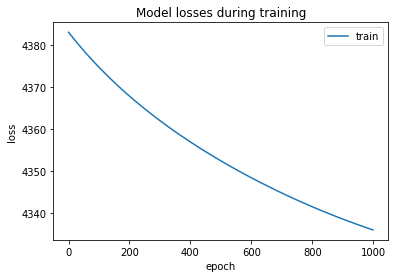

In [57]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"])
plt.title("Model losses during training")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "test"], loc="upper right")
plt.show()

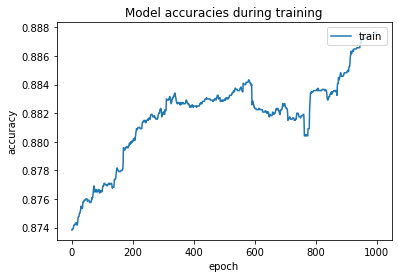

In [60]:
# Plot changes in model accuracy during training
plt.plot(history.history["top_k_categorical_accuracy"])
plt.title("Model accuracies during training")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["train", "test"], loc="upper right")
plt.show()